In [1]:
### Analysing the predicted results and comparing against results elsewhere

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import lasio
import os
import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)
#sys.path.append('../Modules/')
from Modules import rolling_imputer

In [94]:
classifier = pickle.load(open("./model/ReinNN_22_15_3_2021-04-22.pkl", "rb"))
sc_x = pickle.load(open("./model/X_scaler_22_15_3_2021-04-22.pkl", "rb"))
sc_y = pickle.load(open("./model/Y_scaler_22_15_3_2021-04-22.pkl", "rb"))

In [95]:
zone_list = ['Zone_Tertiary', 'Zone_Paleocene', 'Zone_Chalk', 'Zone_Jurassic']

In [96]:
feature_list = ['DRES', 'DT', 'GR', 'DEN', 'COND', 'CAL']
prep_list = feature_list.copy()
prep_list.append('DTS')
prep_list = [sub + 'WS' for sub in prep_list]
prep_list = prep_list + ['Wellname', 'Depth']

In [97]:
well_list = ['22_14b_5_400_13376_uk24500142400000_1465142_wsr']

In [98]:
well_df = pd.DataFrame()
for i in well_list:
    print(i)
    las = lasio.read("./Test_wells/" + i + ".las", ignore_header_errors=True)
    temp_df = las.df()
    temp_df['Wellname'] = las.well.well.value
    temp_df.Wellname.replace({'/':'-', ' ':''}, regex=True, inplace=True)
    temp_df['Depth'] = temp_df.index
    well_df = well_df.append(temp_df, ignore_index=True)
well_df.head(2)

22_14b_5_400_13376_uk24500142400000_1465142_wsr


,AF10ED,AF20ED,AF30ED,AF60ED,AF90ED,AO10ED,AO20ED,AO30ED,AO60ED,AO90ED,...,RHO8ED,RHOZED,ROPED,ROPWS,SRESWS,TENDED,TENRED,TNPHLSED,Wellname,Depth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22-14b-5,400.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22-14b-5,400.5


In [99]:
well_df = well_df[prep_list].copy()

In [100]:
well_tops_df = pd.read_csv('./data/Well_Tops/WellTops.csv', skiprows=3, header=1)
well_df = well_df.merge(well_tops_df, how='left', left_on=['Wellname'], right_on=['Well'])
well_df['Zone'] = np.where(well_df.Depth<well_df['Top Paleocene'], 'Tertiary', 
                            np.where((well_df.Depth>=well_df['Top Paleocene'])&(well_df.Depth<well_df['Top Chalk']), 'Paleocene',
                                    np.where((well_df.Depth>=well_df['Top Chalk'])&(well_df.Depth<well_df['Base Chalk']), 'Chalk', 
                                            np.where(well_df.Depth>=well_df['Base Chalk'], 'Jurassic', np.NaN))))
# Drop values where wells don't have tops and remove extra columns
well_df.drop(['Well', 'Top Paleocene', 'Top Chalk', 'Base Chalk'], axis=1, inplace=True)
well_df = pd.get_dummies(data=well_df, columns=["Zone"])
well_df.head(2)

,DRESWS,DTWS,GRWS,DENWS,CONDWS,CALWS,DTSWS,Wellname,Depth,Zone_Chalk,Zone_Jurassic,Zone_Paleocene,Zone_Tertiary
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22-14b-5,400.0,0,0,0,1
1,NaN,NaN,29.0292,NaN,NaN,NaN,NaN,22-14b-5,400.5,0,0,0,1


In [101]:
well_df.columns = [col.replace('WS', '') for col in well_df.columns]

In [102]:
well_df.columns

Index(['DRES', 'DT', 'GR', 'DEN', 'COND', 'CAL', 'DTS', 'Wellname', 'Depth',
       'Zone_Chalk', 'Zone_Jurassic', 'Zone_Paleocene', 'Zone_Tertiary'],
      dtype='object')

In [103]:
### Initially run just the DTS as this is the target log, then on all others
well_df = rolling_imputer.rolling_imputer(well_df)
for i in well_df.columns[3:-6]:
    well_df = rolling_imputer.rolling_imputer(well_df, log=i)
well_df.dropna(axis=0, how='any', inplace=True)

In [104]:
well_df.to_csv('./data/analysis/test_anlaysis_set_' + str(dt.datetime.today().strftime('%Y-%m-%d')) + '.csv')

In [116]:
len(well_df)

18422

In [105]:
well_df[feature_list+zone_list]

,DRES,DT,GR,DEN,COND,CAL,Zone_Tertiary,Zone_Paleocene,Zone_Chalk,Zone_Jurassic
7321,0.5625,160.5244,52.6915,1.9455,1777.7778,16.0251,1,0,0,0
7322,0.7204,162.9104,51.4349,2.1462,1388.1178,16.5013,1,0,0,0
7323,0.8374,164.6006,52.2190,1.8522,1194.1724,17.0093,1,0,0,0
7324,0.7893,168.8525,55.6460,1.9089,1266.9453,16.9987,1,0,0,0
7325,0.6533,169.1038,50.9360,2.0849,1530.6904,19.0730,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
25801,1.2498,79.6392,69.4629,2.5897,800.1281,8.3919,0,0,0,1
25802,1.2450,80.2962,69.1894,2.5952,803.2128,8.3864,0,0,0,1
25803,1.2780,80.8546,71.0572,2.6380,782.4726,8.3808,0,0,0,1
25804,1.3012,79.9467,73.0496,2.6289,768.5214,8.3818,0,0,0,1


In [106]:
X_test = sc_x.transform(well_df[feature_list + zone_list].copy())
#y_test = sc_y.transform(well_df.drop(feature_list+ ['Wellname', 'Depth'], axis=1).copy())

In [107]:
well_df["DTS_pred"] = sc_y.inverse_transform(classifier.predict(X_test))
well_df["model_error"] = abs(well_df.DTS -  well_df.DTS_pred)
well_df['linear_pred'] = well_df['DT'] * 3.719058 -133.1844
well_df["linear_error"] = abs(well_df.DTS -  well_df.linear_pred)
well_df['poly_pred'] = 0.02562566*well_df['DT']**2 -1.82903*well_df['DT'] +129.6714
well_df["poly_error"] = abs(well_df.DTS -  well_df.poly_pred)

In [108]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(well_df.DTS, well_df.DTS_pred))}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(well_df.DTS, well_df.DTS_pred, squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(well_df.DTS, well_df.DTS_pred), 4)}")
print(f"Linear MAE score: {np.round(mean_absolute_error(well_df.DTS, well_df.linear_pred))}")
print(f"Linear RMSE score: {np.round(mean_squared_error(well_df.DTS, well_df.linear_pred, squared=False))}")
print(f"Linear R2 score: {np.round(r2_score(well_df.DTS, well_df.linear_pred), 4)}")
print(f"Polynomial MAE score: {np.round(mean_absolute_error(well_df.DTS, well_df.poly_pred))}")
print(f"Polynomial RMSE score: {np.round(mean_squared_error(well_df.DTS, well_df.poly_pred, squared=False))}")
print(f"Polynomial R2 score: {np.round(r2_score(well_df.DTS, well_df.poly_pred), 4)}")

Neural Net MAE score: 82.0
Neural Net RMSE score: 107.0
Neural Net R2 score: 0.5529
Linear MAE score: 38.0
Linear RMSE score: 59.0
Linear R2 score: 0.8652
Polynomial MAE score: 26.0
Polynomial RMSE score: 54.0
Polynomial R2 score: 0.8877


In [109]:
print(well_df.loc[well_df['Depth']> 9000]['linear_error'].mean())
print(well_df.loc[well_df['Depth']> 9000]['poly_error'].mean())
print(well_df.loc[well_df['Depth']> 9000]['model_error'].mean())

23.52089285892491
7.7650548641034804
87.57499156796648


In [110]:
well_df['linear_pred_22_15_04'] = well_df['DT'] * 2.491782 - 56.95399
well_df["linear_error_22_15_04"] = abs(well_df.DTS -  well_df.linear_pred_22_15_04)
well_df['poly_pred_22_15_04'] = 0.01863526*well_df['DT']**2 -0.8781411 * well_df['DT'] + 94.90718
well_df["poly_error_22_15_04"] = abs(well_df.DTS -  well_df.poly_pred_22_15_04)

In [111]:
print(well_df.loc[well_df['Depth']> 9000]['linear_error_22_15_04'].mean())
print(well_df.loc[well_df['Depth']> 9000]['poly_error_22_15_04'].mean())
print(well_df.loc[well_df['Depth']> 9000]['model_error'].mean())

15.544547857180223
7.70484930811264
87.57499156796648


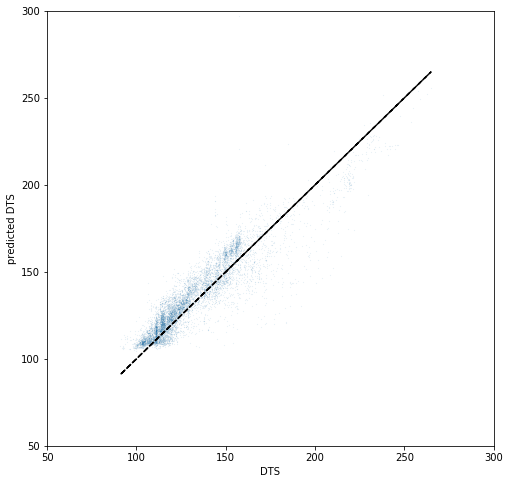

In [91]:
plt.figure(figsize=(8, 8))
plt.scatter(well_df.loc[well_df['Depth']> 9000]['DTS'], well_df.loc[well_df['Depth']> 9000]['DTS_pred'], s=0.001)
plt.plot(well_df.loc[well_df['Depth']> 9000]['DTS'], well_df.loc[well_df['Depth']> 9000]['DTS'], color="black", linestyle="--")
plt.ylim(50, 300)
plt.xlim(50, 300)
plt.xlabel("DTS")
plt.ylabel("predicted DTS")
folder_create = os.path.exists("images")
if folder_create is False:
    os.mkdir("./images")
#plt.savefig('./images/Real_vs_Predicted_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

['22-14b-5']


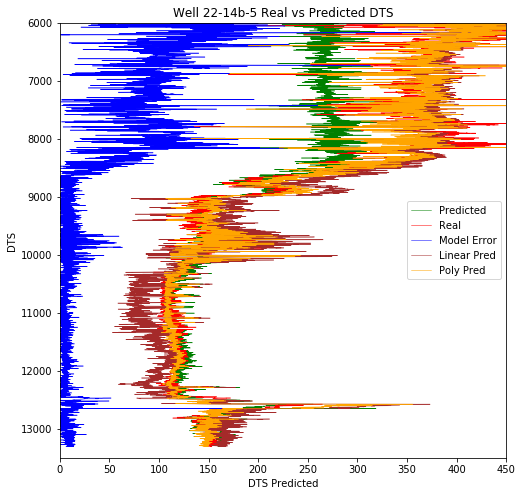

In [97]:
top_count = well_df.Wellname.unique()
print(top_count)
for well in top_count[:100]:
    plt.figure(figsize=(8, 8))
    plt.plot(well_df.loc[well_df['Wellname']==well]['DTS_pred'], well_df.loc[well_df['Wellname']==well]['Depth'], color='green', linewidth=0.5, label='Predicted')
    plt.plot(well_df.loc[well_df['Wellname']==well]['DTS'], well_df.loc[well_df['Wellname']==well]['Depth'], color="red", linewidth=0.5, label='Real') #linestyle="--")
    plt.plot(well_df.loc[well_df['Wellname']==well]['model_error'], well_df.loc[well_df['Wellname']==well]['Depth'], color="blue", linewidth=0.5, label='Model Error') #linestyle="--")
    plt.plot(well_df.loc[well_df['Wellname']==well]['linear_pred'], well_df.loc[well_df['Wellname']==well]['Depth'], color="brown", linewidth=0.5, label='Linear Pred') #linestyle="--")
    plt.plot(well_df.loc[well_df['Wellname']==well]['poly_pred'], well_df.loc[well_df['Wellname']==well]['Depth'], color="orange", linewidth=0.5, label='Poly Pred') #linestyle="--")
    
    plt.xlim(0, 450)
    #plt.xscale('log')
    plt.ylim(6000, 13500)
    plt.title('Well ' + well + ' Real vs Predicted DTS')
    plt.xlabel("DTS Predicted")
    plt.ylabel("DTS")
    plt.gca().invert_yaxis()
    plt.legend()
    #plt.savefig(str(well) + '_Real_vs_Predicted_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')
    plt.show()

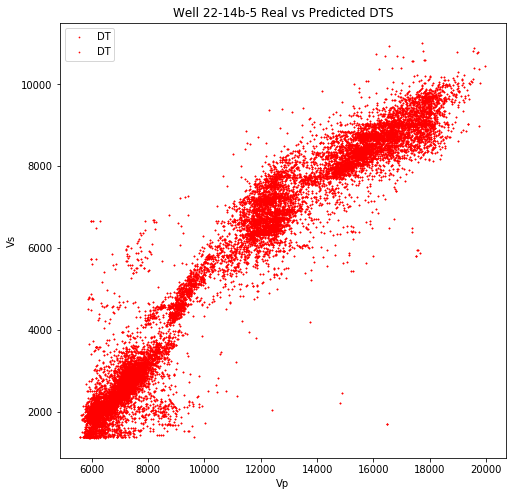

In [100]:
top_count = well_df.Wellname.unique()
for well in top_count[:100]:
    plt.figure(figsize=(8, 8))
    plt.scatter((1e6 / well_df.loc[well_df['Wellname']==well]['DT']), (1e6 / well_df.loc[well_df['Wellname']==well]['DTS']), color='red', s=0.5, label='DT')
    plt.scatter((1e6 / well_df.loc[well_df['Wellname']==well]['DT']), (1e6 / well_df.loc[well_df['Wellname']==well]['DTS']), color='red', s=0.5, label='DT')
    
    
    #plt.xlim(0, 500)
    #plt.xscale('log')
    #plt.ylim(8000, 13500)
    plt.title('Well ' + well + ' Real vs Predicted DTS')
    plt.xlabel("Vp")
    plt.ylabel("Vs")
    plt.legend()
    #plt.savefig(str(well) + '_Real_vs_Predicted_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')
    plt.show()